# Understanding TargetPixelFile objects

## Learning goals

In this tutorial we will learn the following, 
 - What a TESS Target Pixel File (TPF) is. 
 - How to obtain a TPF from the [MAST archive](https://archive.stsci.edu/tess/) via *Lightkurve*.
 - How to plot the TPF image.
 - How to access the metadata, and understand the file properties and units.

We will also show the user where they can find more details about TESS Target Pixel Files.

## What is a Target Pixel File?
The *TESS* telescope observes stars for long periods of time, just under a month per sector. By doing so *TESS* observes how the brightnesses of a star change over time.

Not all data for the stars in a given sector is recorded. Instead, pixels are selected around certain targeted stars. These cut-out images are called Target Pixel Files, or TPFs. By combining the amount of flux in the pixels where the star appears, you can make a measurement of the amount of light form a star in that observation.

TPFs can be thought of as stacks of images, with one image for every telescopic time-stamp. Each time-stamp is referred to as a **cadence**. The TPF images are cut out 'postage stamps' of the full observations, making them easier to work with. TPFs also include information about the astronomical *background* to the image, which is removed from the raw flux.

TPF files are stored in a [FITS file format](https://fits.gsfc.nasa.gov/fits_primer.html). The *Lightkurve* package allows us to work with FITS files without having to directly handle its detailed file structure.

TPFs are typically the first port of call when studying a star with *TESS*. They allow us to see where our data is coming from, and identify potential sources of noise or systematic trends.

In this tutorial we'll cover the basics of working with TPFs in *Lightkurve* using the [`TessTargetPixelFile`](https://docs.lightkurve.org/api/lightkurve.targetpixelfile.TessTargetPixelFile.html?highlight=tesstargetpixelfile) class.

## Imports
This tutorial requires:
- **[Lightkurve](https://docs.lightkurve.org)** to work with TPF files.
- [**Matplotlib**](https://matplotlib.org/) for plotting.

In [1]:
%matplotlib inline 
import lightkurve as lk
import matplotlib.pyplot as plt

## Defining terms

- Target Pixel File (TPF): A file containing the original CCD pixel observations from which light curves are extracted. 

- Cadence: The rate at which TESS photometric observations are stored. 

- Sector: One of TESS's 28 (to date) observing periods, approximately ~27 days in duration. 

## Downloading data
The TPFs of stars observed by the *TESS* mission are stored on the [Mikulksi Archive for Space Telescopes](https://archive.stsci.edu/tess/) (MAST) archive, along with metadata about the observations, such as the CCD used.

Besides raw data measured by the CCD, it will also carry information about the astronomical background, and the recommended aperture for extracting flux.

You can search for a TPF using the [`search_targetpixelfile()`](https://docs.lightkurve.org/api/lightkurve.search.search_targetpixelfile.html#lightkurve.search.search_targetpixelfile) function. This will search for the right file in the MAST data archive.

Note here that `search_targetpixelfile` can take several inputs as listed below, only the first is required,

1. The ID number or name for the object of interest 

2. The mission that the object has been observed in.
    
3. Which part of the survey you want to obtain the data from. The *TESS* the survey is divided up into sectors.
    
4. The quality of the data you want to obtain. This is set using the keyword `quality_bitmask` and more information about this and can be found [here](https://docs.lightkurve.org/api/lightkurve.utils.KeplerQualityFlags.html#lightkurve.utils.KeplerQualityFlags.DEFAULT_BITMASK). 

In this case we want the Target Pixel File with TESS ID - TIC 307210830, which refers to [L 98-59](https://arxiv.org/pdf/1903.08017.pdf), a bright M dwarf star at a distance of 10.6 pc. This star is host to three terrestrial-sized planets.  

In [2]:
search_result = lk.search_targetpixelfile('TIC 307210830')
search_result

#,observation,author,target_name,productFilename,distance
0,TESS Sector 2,SPOC,307210830,tess2018234235059-s0002-0000000307210830-0121-s_tp.fits,0.0
1,TESS Sector 5,SPOC,307210830,tess2018319095959-s0005-0000000307210830-0125-s_tp.fits,0.0
2,TESS Sector 8,SPOC,307210830,tess2019032160000-s0008-0000000307210830-0136-s_tp.fits,0.0
3,TESS Sector 9,SPOC,307210830,tess2019058134432-s0009-0000000307210830-0139-s_tp.fits,0.0
4,TESS Sector 10,SPOC,307210830,tess2019085135100-s0010-0000000307210830-0140-s_tp.fits,0.0
5,TESS Sector 11,SPOC,307210830,tess2019112060037-s0011-0000000307210830-0143-s_tp.fits,0.0
6,TESS Sector 12,SPOC,307210830,tess2019140104343-s0012-0000000307210830-0144-s_tp.fits,0.0


The search function returns a [`SearchResult`](https://docs.lightkurve.org/api/lightkurve.search.SearchResult.html) object, displaying a list. 

In this list, each row represents a different observing period. We find that *TESS* recorded 7 sectors of data for this target across 1 year. The **observation** column lists the TESS sector. The **target_name** represents the TESS Input Catalogue (TIC) ID of the target, and the **productFilename** column is the name of the FITS files downloaded from MAST. The **distance** column shows the separation on the sky between the searched coordinates and the downloaded objects--- this is only relevant when searching for specific coordinates in the sky, and not when looking for individual objects.

The `SearchResult` object also has several convenient operations, for example, we can select the second data product in the list as follows:

In [3]:
search_result[1]

#,observation,author,target_name,productFilename,distance
0,TESS Sector 5,SPOC,307210830,tess2018319095959-s0005-0000000307210830-0125-s_tp.fits,0.0


This allows us look at the TPF from sector 5 only. Let's now download this data via the `download()` method. Note that we want to specify the quality of the data that we are obtaining, and as such use quality_bitmask='default'

In [4]:
tpf_file = search_result[1].download(quality_bitmask='default')
tpf_file

TessTargetPixelFile(TICID: 307210830)

The above code has created a variable named `tpf_file` which is a Python object of type `TessTargetPixelFile`.
You would get the same result if you used the following code instead,
```
tpf_file = lk.search_targetpixelfile('TIC 307210830', mission="TESS", sector=5).download(quality_bitmask='default')
```
This file object provides a convenient way to interact with the data file that has been returned by the archive, which contains both the TPF as well as metadata about the observations.

Before diving into the properties of the `TessTargetPixelFile`, we can plot the data, also using *Lightkurve*.

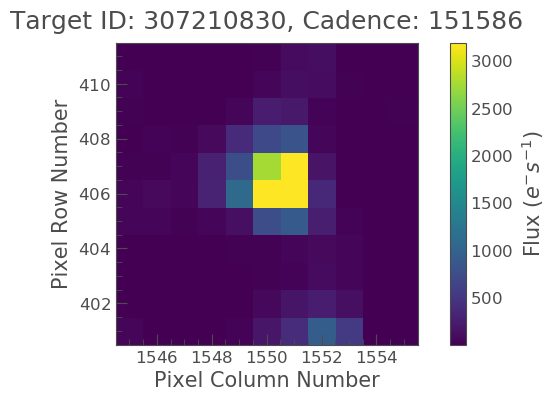

In [5]:
%matplotlib inline
tpf_file.plot();

The above figure indicates the pixels on the CCD camera, with which L 98-59 was observed. The color indicates the amount of flux in each pixel, in electrons per second. The y-axis shows the pixel row, and the x-axis shows the pixel column. The title tells us the *TESS* Input Catalogue ([TIC](https://tess.mit.edu/science/tess-input-catalogue/)) identification number of the target, and the observing cadence of this image. By default, `plot()` shows the first observation cadence in the Sector.

It looks like our star is isolated, so we can extract a light-curve by simply summing up all the pixel values in each image. To do this we use the [`to_lightcurve`](https://docs.lightkurve.org/api/lightkurve.targetpixelfile.KeplerTargetPixelFile.html#lightkurve.targetpixelfile.KeplerTargetPixelFile.to_lightcurve) function which collects the flux of an object from specified pixels, i.e., an aperture mask. How to do this is explained within the [LightCurve Object](LightCurve-object-Tutorial.html) tutorial.

### Note

You can also download TPF FITS files from the archive by hand, store them on your local disk, and open them using the [`lk.open(<filename>)`](http://docs.lightkurve.org/api/lightkurve.search.open.html?highlight=open#lightkurve.search.open) function. This function will return a `TessTargetPixelFile` object just as in the above example.

## Accessing the metadata

Our `TessTargetPixelFile` has lots of information from MAST about the observation, this data is dubbed `metadata`. 

Most `metadata` are stored in the headers of the FITS files. These can be accessed from the `TessTargetPixelFile` through the get_header() method.

For example, the first extension ("extension 0") of the file provides metadata related to the star, such as its magnitude in different passbands, its movement and position on the sky, and its location on *TESS's* CCD detector:


In [6]:
tpf_file.get_header(ext=0)

SIMPLE  =                    T / conforms to FITS standards                     
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T / file contains extensions                       
NEXTEND =                    3 / number of standard extensions                  
EXTNAME = 'PRIMARY '           / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
SIMDATA =                    F / file is based on simulated data                
ORIGIN  = 'NASA/Ames'          / institution responsible for creating this file 
DATE    = '2019-02-10'         / file creation date.                            
TSTART  =    1437.976957548360 / observation start time in TJD                  
TSTOP   =    1464.288062220275 / observation stop time in TJD                   
DATE-OBS= '2018-11-15T11:25:

This is an AstroPy [`astropy.io.fits.Header`](https://docs.astropy.org/en/stable/io/fits/api/headers.html) object, which has many convenient features. For example, you can retrieve the value of an individual keyword as follows:

In [7]:
tpf_file.get_header(ext=0)['Sector']

5

When constructing a `TessTargetPixelFile`from a FITS file, *Lightkurve* carries a subset of the `metadata` through into user-friendly object properties for convenience. You can view these data via the following,

In [8]:
tpf_file.show_properties()

   Attribute                                                                            Description                                                                        
--------------- -----------------------------------------------------------------------------------------------------------------------------------------------------------
         camera                                                                                                                                                           4
            ccd                                                                                                                                                           4
         column                                                                                                                                                        1545
            row                                                                                                                             

This means that there are a small number of very common keywords/columns have a shorthand alias which you can call via *Lightkurve*, see below.

In [9]:
tpf_file.sector

5

In [10]:
tpf_file.mission

'TESS'

In [11]:
tpf_file.ra

124.5319

You can view other data resources stored in this extension by viewing the associated FITS header, for example the cadence number.

In [12]:
tpf_file.hdu[1].data['cadenceno']

array([151576, 151577, 151578, ..., 170517, 170518, 170519], dtype=int32)

We can also look at the values in the second extension of the fits file by accessing the AstroPy FITS `HDUList` object. For example, to look at all the column titles:

In [13]:
tpf_file.hdu[1].header

XTENSION= 'BINTABLE'           / marks the beginning of a new HDU               
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2448 / length of first array dimension                
NAXIS2  =                18944 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
TFIELDS =                   11 / number of table fields                         
TTYPE1  = 'TIME    '           / column title: data time stamps                 
TFORM1  = 'D       '           / column format: 64-bit floating point           
TUNIT1  = 'BJD - 2457000, days' / column units: Barycenter corrected TESS Julian
TDISP1  = 'D14.7   '           / column display format                          
TTYPE2  = 'TIMECORR'        

This is a lot of information to process and if you would prefer to only look at certain items you can specify a string such as `'TYPE'` for instance:

In [14]:
tpf_file.hdu[1].header['TTYPE*']

TTYPE1  = 'TIME    '           / column title: data time stamps                 
TTYPE2  = 'TIMECORR'           / column title: barycentric correction           
TTYPE3  = 'CADENCENO'          / column title: unique cadence number            
TTYPE4  = 'RAW_CNTS'           / column title: raw pixel counts                 
TTYPE5  = 'FLUX    '           / column title: calibrated pixel flux            
TTYPE6  = 'FLUX_ERR'           / column title: 1-sigma calibrated uncertainty   
TTYPE7  = 'FLUX_BKG'           / column title: calibrated background flux       
TTYPE8  = 'FLUX_BKG_ERR'       / column title: 1-sigma cal. background uncertain
TTYPE9  = 'QUALITY '           / column title: pixel quality flags              
TTYPE10 = 'POS_CORR1'          / column title: column position correction       
TTYPE11 = 'POS_CORR2'          / column title: row position correction          

You can find more information on FITS file handeling [here](https://docs.astropy.org/en/stable/io/fits/)

## WCS
A new piece of `metadata` included in the `TessTargetPixelFile` objects is the [World Coordinate System](https://fits.gsfc.nasa.gov/fits_wcs.html) (WCS). The WCS contains information about how pixel numbers map to celestial coordinates. This is important when comparing a TPF from a *TESS* observation to an observation of the same star with a different telescope.

In [15]:
print(f'WCS: {tpf_file.wcs}')

WCS: WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 124.5332711499119  -68.31478618755017  
CRPIX : 6.441276957091532  6.350830655251798  
PC1_1 PC1_2  : -0.5337830820472862  0.8130667476670455  
PC2_1 PC2_2  : 0.8497123440435488  0.5791250385649829  
CDELT : -0.0054863849277  0.005486384927700364  
NAXIS : 2448  18944


## Flux & time

The most interesting data in a *TESS* `TargetPixelFile` object are the `flux` and `time`, which give access to the brightness of the observed target over time. 

### Time

You can access the time-stamps of the observations using the `time` property:

In [16]:
tpf_file.time

<Time object: scale='tdb' format='btjd' value=[1437.99041283 1437.99180173 1437.99319063 ... 1464.28387565 1464.28526456
 1464.28665347]>

By default, `time` is in the TESS Barycentric Julian Day (BTJD), this is a Julian day minus 2457000.0 and corrected to the arrival times at the barycenter of the Solar System. BTJD is the format in which times are recorded in the TESS data products. The time is in the Barycentric Dynamical Time frame (TDB), which is a time system that is not affected by leap seconds, see the [TESS Science Data Products Description
Document](https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/20180007935.pdf) for more details.

In turn, this gives you access to human-readable ISO timestamps using the `astropy_time.iso` property:

In [17]:
tpf_file.time.iso

array(['2018-11-15 11:46:11.668', '2018-11-15 11:48:11.669',
       '2018-11-15 11:50:11.670', ..., '2018-12-11 18:48:46.856',
       '2018-12-11 18:50:46.858', '2018-12-11 18:52:46.860'], dtype='<U23')

**Beware:** because these time-stamps are in the TDB frame they do not include corrections for light travel time or leap seconds. To use a different time scale, such as the Earth-centered UTC system, you can use [AstroPy's time scale conversion features](http://docs.astropy.org/en/stable/time/#time-scale). For example: 

In [18]:
tpf_file.time.utc.iso

array(['2018-11-15 11:45:02.486', '2018-11-15 11:47:02.487',
       '2018-11-15 11:49:02.488', ..., '2018-12-11 18:47:37.673',
       '2018-12-11 18:49:37.675', '2018-12-11 18:51:37.676'], dtype='<U23')

### Flux

Next, let's look at the actual image data, which is available via the flux property.

At each cadence the TPF has a number of photometry data properties. These can be found using the following properites,

- flux_bkg: the astronomical background of the image.

- flux_bkg_err: the statistical uncertainty on the background flux.

- flux: the stellar flux after the background is removed.

- flux_err: the statistical uncertainty on the stellar flux after background removal.

These properties can be accessed from the TPF directly (as tpf_file.flux), or from the TPF FITS file, where they are stored in extension 1. Let's first look at the shape of the data.

In [19]:
tpf_file.flux.shape

(17894, 11, 11)

The `flux` data is a 17894x11x11 array in units electrons/second. The first axis is the time axis, and the images themselves are 11 pixels by 11 pixels. As shown previously you can use the `plot` method on the `TessTargetPixelFile` object to view the data. Let's look at the flux.

In [20]:
tpf_file.flux 
tpf_file.cadenceno

array([151586, 151587, 151588, ..., 170517, 170518, 170519], dtype=int32)

In [21]:
tpf_file.hdu[1].data['FLUX']
tpf_file.hdu[1].data['cadenceno']

array([151576, 151577, 151578, ..., 170517, 170518, 170519], dtype=int32)

Note that you **do not** get the same result if you do `tpf_file.hdu[1].data['FLUX']`, the tpf_file.flux is the flux once a quality mask has been applied. Make sure if you compare tpf_file.hdu[1].data['FLUX'] to tpf_file flux you are comparing the same cadence number.

You can use normal `numpy` methods on these arrays to find the mean etc!

#### Understanding the flux

When plotting data using the plot() function as we did above, what you are seeing in the TPF is the flux after the background has been removed. This background flux typically consists of zodiacal light or earthshine (especially in TESS observations). The background is typically smooth and changes on scales much larger than a single TPF. In *TESS*, the background is estimated for the CCD as a whole, before being extracted from each TPF in that CCD.


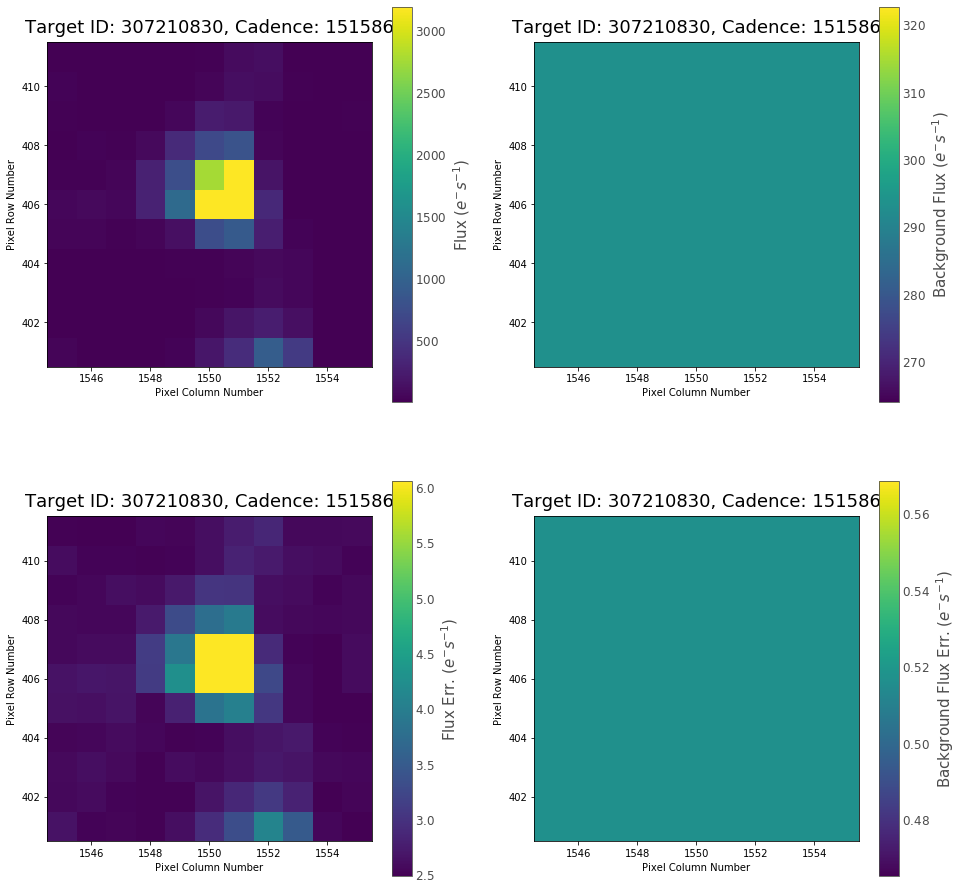

In [22]:
%matplotlib inline
fig, axes = plt.subplots(2,2, figsize=(16,16))
tpf_file.plot(ax = axes[0,0], column = 'FLUX')
tpf_file.plot(ax = axes[0,1], column = 'FLUX_BKG')
tpf_file.plot(ax = axes[1,0], column = 'FLUX_ERR')
tpf_file.plot(ax = axes[1,1], column = 'FLUX_BKG_ERR');

From looking at the color scale on both plots, you may see that the background flux is very low compared to the total flux emitted by a star, maximum of ~320 e-/s. This is expected --- stars are bright! But these small background corrections become important when looking at the very small scale changes caused by planets or stellar oscillations. Understanding the background is an important part of astronomy with  *TESS*.
 
If the background is particularly bright and you want to see what the TPF looks like with it included, passing the `bkg=True` argument to the `plot()` method will show the TPF with the flux summed on top of the subtracted background, representing the raw flux recorded by the spacecraft.

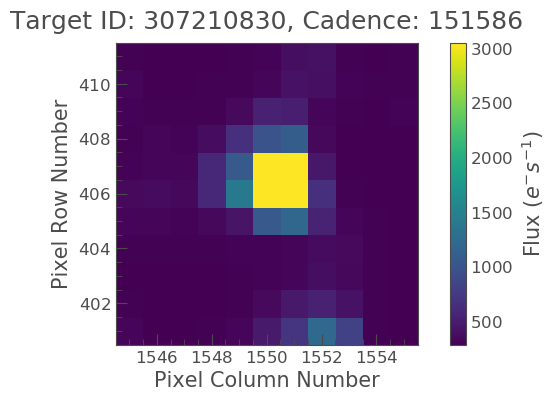

In [23]:
tpf_file.plot(bkg=True);

In this case the background is low and the star is bright, so it doesn't appear to make much difference.